In [1]:
# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


#model selection
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Add,Dropout, Dense, Activation, ZeroPadding2D, \
BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D
#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
import PIL
import PIL.Image

import glob   
import shutil


In [2]:
data_dir = os.curdir + "/Flowers"
# Training data dir
training_dir = os.curdir + '/Train'

val_dir = os.curdir + '/Validation'

# Test data dir
testing_dir = os.curdir + '/Test'

# Ratio of training and testing data
train_test_ratio = 0.8 

def split_dataset_into_test_and_train_sets(all_data_dir = data_dir, training_data_dir = training_dir, \
                                           testing_data_dir=testing_dir, validation_data_dir = val_dir, train_test_ratio = 0.8):
    # Recreate testing and training directories
    
    if not os.path.exists(training_data_dir):
            os.mkdir(training_data_dir)

    if not os.path.exists(testing_data_dir):
            os.mkdir(testing_data_dir)        
            
    if not os.path.exists(validation_data_dir):
        os.mkdir(validation_data_dir)        
    
    num_training_files = 0
    num_testing_files = 0
    num_validation_files = 0


    for subdir, dirs, files in os.walk(all_data_dir):
        
        category_name = os.path.basename(subdir)
        
        # print(category_name + " vs " + os.path.basename(all_data_dir))
        if category_name == os.path.basename(all_data_dir):
              continue

        training_data_category_dir = training_data_dir + '/' + category_name
        testing_data_category_dir = testing_data_dir + '/' + category_name
        validation_data_category_dir = validation_data_dir + '/' + category_name
        
        # creating subdir for each sub category
        if not os.path.exists(training_data_category_dir):
            os.mkdir(training_data_category_dir)   

        if not os.path.exists(testing_data_category_dir):
            os.mkdir(testing_data_category_dir)
            
        if not os.path.exists(validation_data_category_dir):
            os.mkdir(validation_data_category_dir)
            
        file_list = glob.glob(os.path.join(subdir,'*.jpg'))

        #print(os.path.join(all_data_dir, subdir))
        print(str(category_name) + ' has ' + str(len(files)) + ' images') 
        random_set = np.random.permutation((file_list))
        # copy percentage of data from each category to train and test directory
        train_list = random_set[:round(len(random_set)*(0.6))] 
        test_list = random_set[-round(len(random_set)*(0.2)):]
        val_list = random_set[-round(len(random_set)*(0.2)):]

        for lists in train_list : 
            shutil.copy(lists, training_data_dir + '/' + category_name + '/' )
            num_training_files += 1
  
        for lists in test_list : 
            shutil.copy(lists, testing_data_dir + '/' + category_name + '/' )
            num_testing_files += 1
            
        for lists in val_list : 
            shutil.copy(lists, validation_data_dir + '/' + category_name + '/' )
            num_validation_files += 1
  
  

    print("Processed " + str(num_training_files) + " training files.")
    print("Processed " + str(num_testing_files) + " testing files.")
    print("Processed " + str(num_validation_files) + " validation files.")

In [3]:
split_dataset_into_test_and_train_sets()

Babi has 931 images
Calimerio has 353 images
Chrysanthemum has 696 images
Hydrangeas has 518 images
Lisianthus has 969 images
Pingpong has 360 images
Rosy has 171 images
Tana has 623 images
Processed 3696 training files.
Processed 925 testing files.


In [71]:
# Defining the imagedatagenerator for train and test image for pre-processing
# We don't give horizonal_flip or other preprocessing for validation data generator
data_dir = os.curdir + "/Flowers"
# Training data dir
training_dir = os.curdir + '/Train'

# Test data dir
testing_dir = os.curdir + '/Test'

val_dir = os.curdir + '/Validation'

image_size = 224
batch_size = 64

train_data_gen = ImageDataGenerator(
    rescale = 1./255, #normalization
    rotation_range = 40,
    width_shift_range = 0.4,
    height_shift_range = 0.4,
    shear_range = 0.2,
    zoom_range = 0.1,
    fill_mode = 'nearest',
    horizontal_flip = True)
valid_data_gen = ImageDataGenerator(rescale = 1./255)
train_generator = train_data_gen.flow_from_directory(training_dir, (image_size,image_size), batch_size=batch_size, class_mode='categorical')
valid_generator = valid_data_gen.flow_from_directory(val_dir, (image_size,image_size), batch_size=batch_size, class_mode='categorical')
test_generator = valid_data_gen.flow_from_directory(testing_dir, (image_size,image_size), batch_size=batch_size, class_mode='categorical', shuffle = False)

Found 2774 images belonging to 8 classes.
Found 925 images belonging to 8 classes.
Found 925 images belonging to 8 classes.


In [21]:
def create_cnn_model(dropout_rate, learning_rate):
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (224,224,3)))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
    model.add(Dropout(dropout_rate))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
    model.add(Dropout(dropout_rate))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name = 'encoder'))
    model.add(Flatten())

    model.add(Dense(512, activation = 'relu'))
    model.add(Dropout(dropout_rate))

    model.add(Dense(8, activation = "softmax"))
    # Compile model
    model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy',metrics=['accuracy'])  
    return model

Epoch 1/50
57/57 [==============================] - 116s 2s/step - loss: 1.9968 - accuracy: 0.2040 - val_loss: 1.9823 - val_accuracy: 0.2143
Epoch 2/50
57/57 [==============================] - 112s 2s/step - loss: 1.9762 - accuracy: 0.2161 - val_loss: 1.9705 - val_accuracy: 0.2143
Epoch 3/50
57/57 [==============================] - 112s 2s/step - loss: 1.9711 - accuracy: 0.2241 - val_loss: 1.9693 - val_accuracy: 0.2746
Epoch 4/50
57/57 [==============================] - 113s 2s/step - loss: 1.9628 - accuracy: 0.2365 - val_loss: 1.9573 - val_accuracy: 0.2812
Epoch 5/50
57/57 [==============================] - 113s 2s/step - loss: 1.9577 - accuracy: 0.2472 - val_loss: 1.9476 - val_accuracy: 0.2567
Epoch 6/50
57/57 [==============================] - 113s 2s/step - loss: 1.9421 - accuracy: 0.2572 - val_loss: 1.9370 - val_accuracy: 0.2902
Epoch 7/50
57/57 [==============================] - 112s 2s/step - loss: 1.9332 - accuracy: 0.2616 - val_loss: 1.9187 - val_accuracy: 0.2891
Epoch 8/50
57

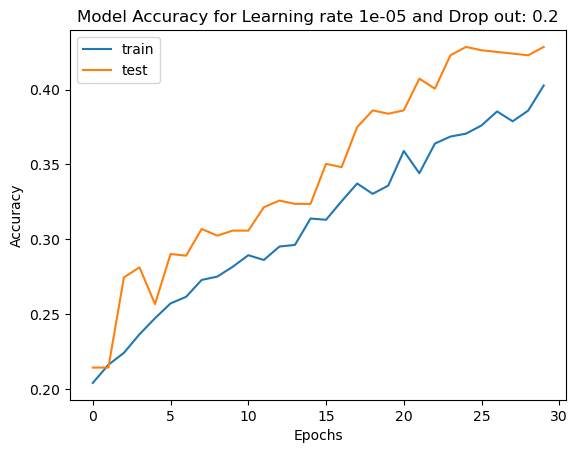

Epoch 1/50
57/57 [==============================] - 112s 2s/step - loss: 2.0002 - accuracy: 0.1922 - val_loss: 2.0070 - val_accuracy: 0.2143
Epoch 2/50
57/57 [==============================] - 112s 2s/step - loss: 1.9798 - accuracy: 0.2109 - val_loss: 2.0102 - val_accuracy: 0.2121
Epoch 3/50
57/57 [==============================] - 113s 2s/step - loss: 1.9760 - accuracy: 0.2219 - val_loss: 1.9978 - val_accuracy: 0.2645
Epoch 4/50
57/57 [==============================] - 112s 2s/step - loss: 1.9676 - accuracy: 0.2247 - val_loss: 1.9942 - val_accuracy: 0.2578
Epoch 5/50
57/57 [==============================] - 112s 2s/step - loss: 1.9656 - accuracy: 0.2307 - val_loss: 1.9870 - val_accuracy: 0.2444
Epoch 6/50
57/57 [==============================] - 112s 2s/step - loss: 1.9511 - accuracy: 0.2431 - val_loss: 1.9807 - val_accuracy: 0.3170
Epoch 7/50
57/57 [==============================] - 112s 2s/step - loss: 1.9389 - accuracy: 0.2442 - val_loss: 1.9683 - val_accuracy: 0.2723
Epoch 8/50
57

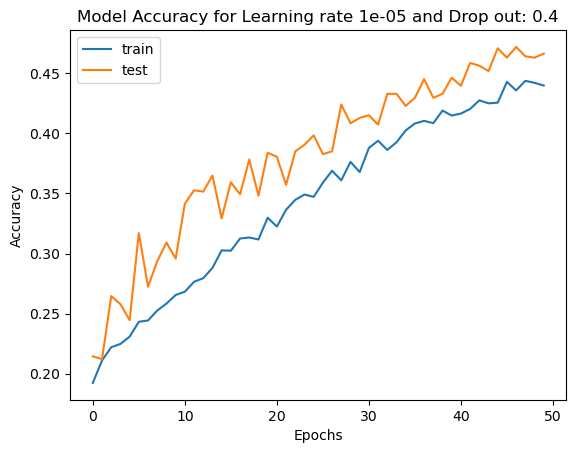

Epoch 1/50
57/57 [==============================] - 113s 2s/step - loss: 1.9747 - accuracy: 0.2159 - val_loss: 1.9475 - val_accuracy: 0.2377
Epoch 2/50
57/57 [==============================] - 113s 2s/step - loss: 1.9180 - accuracy: 0.2662 - val_loss: 1.8857 - val_accuracy: 0.2879
Epoch 3/50
57/57 [==============================] - 113s 2s/step - loss: 1.8464 - accuracy: 0.2941 - val_loss: 1.7810 - val_accuracy: 0.3225
Epoch 4/50
57/57 [==============================] - 113s 2s/step - loss: 1.7803 - accuracy: 0.3318 - val_loss: 1.6885 - val_accuracy: 0.3817
Epoch 5/50
57/57 [==============================] - 113s 2s/step - loss: 1.7096 - accuracy: 0.3717 - val_loss: 1.6271 - val_accuracy: 0.3962
Epoch 6/50
57/57 [==============================] - 114s 2s/step - loss: 1.6537 - accuracy: 0.3970 - val_loss: 1.5629 - val_accuracy: 0.4353
Epoch 7/50
57/57 [==============================] - 113s 2s/step - loss: 1.6038 - accuracy: 0.4180 - val_loss: 1.5042 - val_accuracy: 0.4866
Epoch 8/50
57

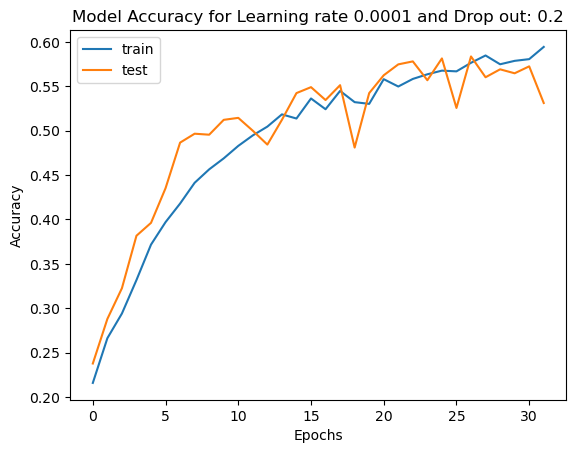

Epoch 1/50
57/57 [==============================] - 112s 2s/step - loss: 1.9901 - accuracy: 0.2059 - val_loss: 1.9864 - val_accuracy: 0.2623
Epoch 2/50
57/57 [==============================] - 113s 2s/step - loss: 1.9541 - accuracy: 0.2439 - val_loss: 1.9663 - val_accuracy: 0.3047
Epoch 3/50
57/57 [==============================] - 112s 2s/step - loss: 1.9056 - accuracy: 0.2676 - val_loss: 1.8805 - val_accuracy: 0.3471
Epoch 4/50
57/57 [==============================] - 113s 2s/step - loss: 1.8321 - accuracy: 0.3108 - val_loss: 1.8133 - val_accuracy: 0.3917
Epoch 5/50
57/57 [==============================] - 114s 2s/step - loss: 1.7620 - accuracy: 0.3439 - val_loss: 1.7426 - val_accuracy: 0.3917
Epoch 6/50
57/57 [==============================] - 113s 2s/step - loss: 1.6927 - accuracy: 0.3775 - val_loss: 1.6833 - val_accuracy: 0.4431
Epoch 7/50
57/57 [==============================] - 112s 2s/step - loss: 1.6147 - accuracy: 0.4089 - val_loss: 1.6263 - val_accuracy: 0.4688
Epoch 8/50
57

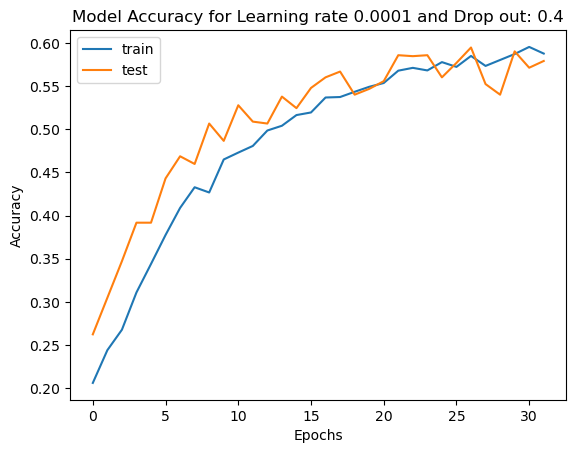

Epoch 1/50
57/57 [==============================] - 113s 2s/step - loss: 2.0766 - accuracy: 0.2070 - val_loss: 1.9914 - val_accuracy: 0.2031
Epoch 2/50
57/57 [==============================] - 113s 2s/step - loss: 1.9597 - accuracy: 0.2346 - val_loss: 1.8711 - val_accuracy: 0.3203
Epoch 3/50
57/57 [==============================] - 111s 2s/step - loss: 1.9174 - accuracy: 0.2706 - val_loss: 1.9201 - val_accuracy: 0.3080
Epoch 4/50
57/57 [==============================] - 112s 2s/step - loss: 1.8393 - accuracy: 0.3111 - val_loss: 1.7709 - val_accuracy: 0.3538
Epoch 5/50
57/57 [==============================] - 113s 2s/step - loss: 1.7492 - accuracy: 0.3676 - val_loss: 1.6701 - val_accuracy: 0.3996
Epoch 6/50
57/57 [==============================] - 112s 2s/step - loss: 1.6252 - accuracy: 0.4061 - val_loss: 1.5626 - val_accuracy: 0.4096
Epoch 7/50
57/57 [==============================] - 112s 2s/step - loss: 1.5701 - accuracy: 0.4265 - val_loss: 1.5901 - val_accuracy: 0.3895
Epoch 8/50
57

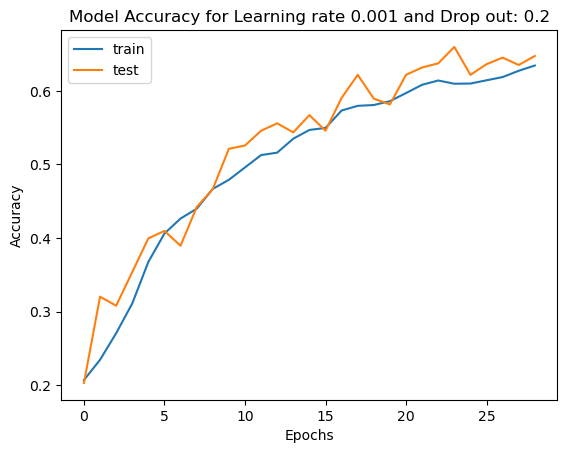

Epoch 1/50
57/57 [==============================] - 112s 2s/step - loss: 2.0767 - accuracy: 0.1982 - val_loss: 1.9939 - val_accuracy: 0.2087
Epoch 2/50
57/57 [==============================] - 111s 2s/step - loss: 1.9372 - accuracy: 0.2398 - val_loss: 1.9283 - val_accuracy: 0.3147
Epoch 3/50
57/57 [==============================] - 112s 2s/step - loss: 1.8694 - accuracy: 0.3048 - val_loss: 1.8568 - val_accuracy: 0.3259
Epoch 4/50
57/57 [==============================] - 112s 2s/step - loss: 1.8360 - accuracy: 0.3232 - val_loss: 1.8239 - val_accuracy: 0.3147
Epoch 5/50
57/57 [==============================] - 111s 2s/step - loss: 1.7171 - accuracy: 0.3775 - val_loss: 1.6379 - val_accuracy: 0.4509
Epoch 6/50
57/57 [==============================] - 111s 2s/step - loss: 1.5909 - accuracy: 0.4207 - val_loss: 1.6474 - val_accuracy: 0.4621
Epoch 7/50
57/57 [==============================] - 111s 2s/step - loss: 1.5721 - accuracy: 0.4347 - val_loss: 1.5215 - val_accuracy: 0.4766
Epoch 8/50
57

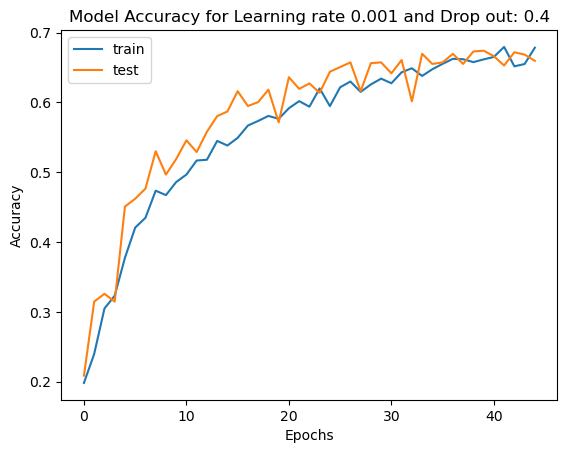

Epoch 1/50
57/57 [==============================] - 111s 2s/step - loss: 8.1481 - accuracy: 0.1925 - val_loss: 1.9686 - val_accuracy: 0.2042
Epoch 2/50
57/57 [==============================] - 111s 2s/step - loss: 1.9750 - accuracy: 0.2040 - val_loss: 1.9730 - val_accuracy: 0.2098
Epoch 3/50
57/57 [==============================] - 110s 2s/step - loss: 1.9733 - accuracy: 0.2084 - val_loss: 1.9729 - val_accuracy: 0.2009
Epoch 4/50
57/57 [==============================] - 111s 2s/step - loss: 1.9731 - accuracy: 0.2098 - val_loss: 1.9707 - val_accuracy: 0.1953
Epoch 5/50
57/57 [==============================] - 110s 2s/step - loss: 1.9733 - accuracy: 0.2051 - val_loss: 1.9652 - val_accuracy: 0.2042
Epoch 6/50
57/57 [==============================] - 111s 2s/step - loss: 1.9737 - accuracy: 0.2128 - val_loss: 1.9738 - val_accuracy: 0.2132
Epoch 7/50
57/57 [==============================] - 111s 2s/step - loss: 1.9727 - accuracy: 0.2137 - val_loss: 1.9705 - val_accuracy: 0.2054
Epoch 8/50
57

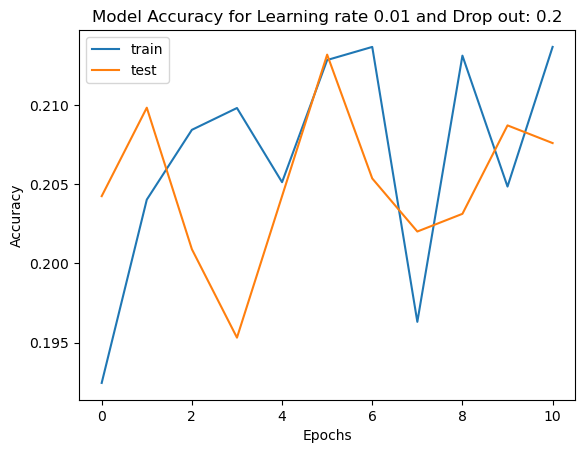

Epoch 1/50
57/57 [==============================] - 112s 2s/step - loss: 24.0682 - accuracy: 0.2051 - val_loss: 1.9748 - val_accuracy: 0.2109
Epoch 2/50
57/57 [==============================] - 111s 2s/step - loss: 1.9796 - accuracy: 0.2059 - val_loss: 1.9695 - val_accuracy: 0.2098
Epoch 3/50
57/57 [==============================] - 111s 2s/step - loss: 1.9765 - accuracy: 0.2046 - val_loss: 1.9686 - val_accuracy: 0.2143
Epoch 4/50
57/57 [==============================] - 116s 2s/step - loss: 1.9745 - accuracy: 0.2084 - val_loss: 1.9700 - val_accuracy: 0.2042
Epoch 5/50
57/57 [==============================] - 111s 2s/step - loss: 1.9721 - accuracy: 0.2010 - val_loss: 1.9702 - val_accuracy: 0.2098
Epoch 6/50
57/57 [==============================] - 111s 2s/step - loss: 1.9718 - accuracy: 0.2026 - val_loss: 1.9722 - val_accuracy: 0.2087
Epoch 7/50
57/57 [==============================] - 110s 2s/step - loss: 1.9748 - accuracy: 0.2093 - val_loss: 1.9732 - val_accuracy: 0.2076
Epoch 8/50
5

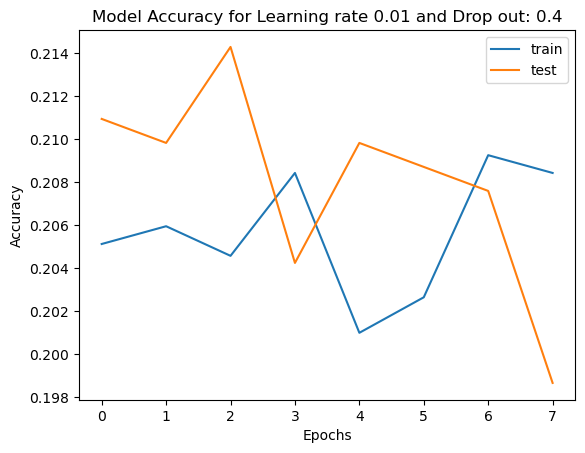

In [11]:
models = []
lr_params = [1e-5, 1e-4, 1e-3, 1e-2]
dropout_params = [0.2, 0.4]
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)

for lr in lr_params:
    for dropout in dropout_params:
        buf = create_cnn_model(dropout, lr)
        history = buf.fit(
        train_generator,
        steps_per_epoch=train_generator.n//batch_size,
        validation_data=valid_generator,
        validation_steps=valid_generator.n//batch_size,
        epochs=50,
        verbose=1, callbacks=[early_stopping])
        
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model Accuracy for Learning rate ' + str(lr) + ' and Drop out: ' + str(dropout))
        plt.ylabel('Accuracy')
        plt.xlabel('Epochs')
        plt.legend(['train', 'test'])
        plt.show()
        models.append(buf)


Epoch 1/80
57/57 [==============================] - 120s 2s/step - loss: 2.0156 - accuracy: 0.2068 - val_loss: 1.9785 - val_accuracy: 0.2087
Epoch 2/80
57/57 [==============================] - 123s 2s/step - loss: 1.9602 - accuracy: 0.2170 - val_loss: 1.9325 - val_accuracy: 0.3259
Epoch 3/80
57/57 [==============================] - 128s 2s/step - loss: 1.9073 - accuracy: 0.2792 - val_loss: 1.8447 - val_accuracy: 0.3192
Epoch 4/80
57/57 [==============================] - 144s 3s/step - loss: 1.8758 - accuracy: 0.2960 - val_loss: 1.8822 - val_accuracy: 0.3158
Epoch 5/80
57/57 [==============================] - 141s 2s/step - loss: 1.8388 - accuracy: 0.3216 - val_loss: 1.8971 - val_accuracy: 0.3259
Epoch 6/80
57/57 [==============================] - 141s 2s/step - loss: 1.8187 - accuracy: 0.3241 - val_loss: 1.7114 - val_accuracy: 0.3917
Epoch 7/80
57/57 [==============================] - 140s 2s/step - loss: 1.7011 - accuracy: 0.3753 - val_loss: 1.5998 - val_accuracy: 0.4408
Epoch 8/80
57

Epoch 59/80
57/57 [==============================] - 105s 2s/step - loss: 0.7515 - accuracy: 0.7299 - val_loss: 0.8282 - val_accuracy: 0.7221
Epoch 60/80
57/57 [==============================] - 104s 2s/step - loss: 0.7655 - accuracy: 0.7274 - val_loss: 0.8292 - val_accuracy: 0.7176
Epoch 61/80
57/57 [==============================] - 104s 2s/step - loss: 0.7463 - accuracy: 0.7365 - val_loss: 0.8193 - val_accuracy: 0.7109
Epoch 62/80
57/57 [==============================] - 104s 2s/step - loss: 0.7600 - accuracy: 0.7274 - val_loss: 0.8419 - val_accuracy: 0.7065
Epoch 63/80
57/57 [==============================] - 104s 2s/step - loss: 0.7484 - accuracy: 0.7324 - val_loss: 0.8223 - val_accuracy: 0.7277
Epoch 64/80
57/57 [==============================] - 105s 2s/step - loss: 0.7306 - accuracy: 0.7368 - val_loss: 0.7780 - val_accuracy: 0.7444
Epoch 65/80
57/57 [==============================] - 104s 2s/step - loss: 0.7111 - accuracy: 0.7453 - val_loss: 0.8465 - val_accuracy: 0.7232
Epoch 

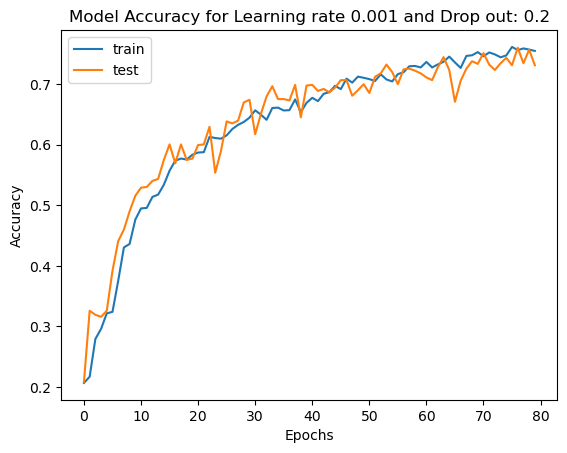

Epoch 1/80
57/57 [==============================] - 105s 2s/step - loss: 8.9121 - accuracy: 0.1798 - val_loss: 1.9723 - val_accuracy: 0.2109
Epoch 2/80
57/57 [==============================] - 104s 2s/step - loss: 1.9739 - accuracy: 0.1958 - val_loss: 1.9664 - val_accuracy: 0.2020
Epoch 3/80
57/57 [==============================] - 113s 2s/step - loss: 1.9728 - accuracy: 0.1985 - val_loss: 1.9714 - val_accuracy: 0.2109
Epoch 4/80
57/57 [==============================] - 115s 2s/step - loss: 1.9729 - accuracy: 0.2051 - val_loss: 1.9646 - val_accuracy: 0.2121
Epoch 5/80
57/57 [==============================] - 113s 2s/step - loss: 1.9719 - accuracy: 0.2079 - val_loss: 1.9685 - val_accuracy: 0.2020
Epoch 6/80
57/57 [==============================] - 116s 2s/step - loss: 1.9732 - accuracy: 0.2013 - val_loss: 1.9665 - val_accuracy: 0.2076
Epoch 7/80
57/57 [==============================] - 115s 2s/step - loss: 1.9734 - accuracy: 0.2029 - val_loss: 1.9743 - val_accuracy: 0.2065
Epoch 8/80
57

Epoch 59/80
57/57 [==============================] - 103s 2s/step - loss: 1.9693 - accuracy: 0.2059 - val_loss: 1.9666 - val_accuracy: 0.2109
Epoch 60/80
57/57 [==============================] - 103s 2s/step - loss: 1.9684 - accuracy: 0.2101 - val_loss: 1.9651 - val_accuracy: 0.2121
Epoch 61/80
57/57 [==============================] - 103s 2s/step - loss: 1.9706 - accuracy: 0.2024 - val_loss: 1.9656 - val_accuracy: 0.2087
Epoch 62/80
57/57 [==============================] - 103s 2s/step - loss: 1.9689 - accuracy: 0.2062 - val_loss: 1.9667 - val_accuracy: 0.2109
Epoch 63/80
57/57 [==============================] - 103s 2s/step - loss: 1.9706 - accuracy: 0.2024 - val_loss: 1.9689 - val_accuracy: 0.2031
Epoch 64/80
57/57 [==============================] - 103s 2s/step - loss: 1.9703 - accuracy: 0.2079 - val_loss: 1.9655 - val_accuracy: 0.2109
Epoch 65/80
57/57 [==============================] - 103s 2s/step - loss: 1.9702 - accuracy: 0.2007 - val_loss: 1.9710 - val_accuracy: 0.2132
Epoch 

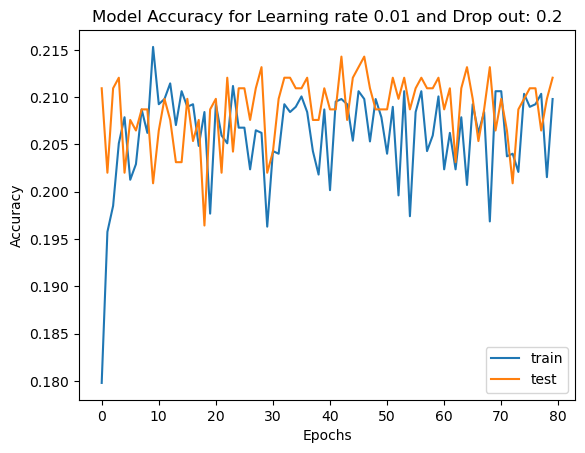

Epoch 1/80
57/57 [==============================] - 106s 2s/step - loss: 2.0714 - accuracy: 0.2046 - val_loss: 1.9884 - val_accuracy: 0.2467
Epoch 2/80
57/57 [==============================] - 104s 2s/step - loss: 1.9758 - accuracy: 0.1955 - val_loss: 1.9750 - val_accuracy: 0.2098
Epoch 3/80
57/57 [==============================] - 104s 2s/step - loss: 1.9600 - accuracy: 0.2324 - val_loss: 1.9237 - val_accuracy: 0.3069
Epoch 4/80
57/57 [==============================] - 104s 2s/step - loss: 1.9260 - accuracy: 0.2489 - val_loss: 1.9248 - val_accuracy: 0.3170
Epoch 5/80
57/57 [==============================] - 104s 2s/step - loss: 1.8975 - accuracy: 0.2819 - val_loss: 1.8367 - val_accuracy: 0.3962
Epoch 6/80
57/57 [==============================] - 105s 2s/step - loss: 1.7886 - accuracy: 0.3508 - val_loss: 1.6980 - val_accuracy: 0.4364
Epoch 7/80
57/57 [==============================] - 104s 2s/step - loss: 1.6729 - accuracy: 0.4064 - val_loss: 1.5892 - val_accuracy: 0.4654
Epoch 8/80
57

Epoch 59/80
57/57 [==============================] - 104s 2s/step - loss: 0.8848 - accuracy: 0.6856 - val_loss: 0.9655 - val_accuracy: 0.6674
Epoch 60/80
57/57 [==============================] - 104s 2s/step - loss: 0.8544 - accuracy: 0.6977 - val_loss: 0.9402 - val_accuracy: 0.6830
Epoch 61/80
57/57 [==============================] - 103s 2s/step - loss: 0.8813 - accuracy: 0.6850 - val_loss: 1.0223 - val_accuracy: 0.6719
Epoch 62/80
57/57 [==============================] - 104s 2s/step - loss: 0.8770 - accuracy: 0.6878 - val_loss: 0.9782 - val_accuracy: 0.6607
Epoch 63/80
57/57 [==============================] - 104s 2s/step - loss: 0.8424 - accuracy: 0.6960 - val_loss: 0.9650 - val_accuracy: 0.6830
Epoch 64/80
57/57 [==============================] - 103s 2s/step - loss: 0.8687 - accuracy: 0.6985 - val_loss: 0.9875 - val_accuracy: 0.6462
Epoch 65/80
57/57 [==============================] - 104s 2s/step - loss: 0.8341 - accuracy: 0.7007 - val_loss: 0.9249 - val_accuracy: 0.6696
Epoch 

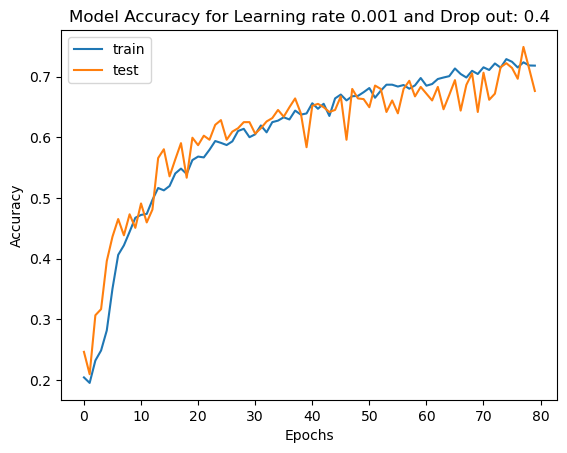

Epoch 1/80
45/57 [======================>.......] - ETA: 20s - loss: 7.0219 - accuracy: 0.1903

KeyboardInterrupt: 

In [16]:
models = []
lr_params = [1e-3, 1e-2]
dropout_params = [0.2, 0.4]

for dropout in dropout_params:
    for lr in lr_params:
        buf = create_cnn_model(dropout, lr)
        history = buf.fit(
        train_generator,
        steps_per_epoch=train_generator.n//batch_size,
        validation_data=valid_generator,
        validation_steps=valid_generator.n//batch_size,
        epochs=80,
        verbose=1)
        
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model Accuracy for Learning rate ' + str(lr) + ' and Drop out: ' + str(dropout))
        plt.ylabel('Accuracy')
        plt.xlabel('Epochs')
        plt.legend(['train', 'test'])
        plt.show()
        models.append(buf)


Epoch 1/80
57/57 [==============================] - 120s 2s/step - loss: 2.0156 - accuracy: 0.2068 - val_loss: 1.9785 - val_accuracy: 0.2087
Epoch 2/80
57/57 [==============================] - 123s 2s/step - loss: 1.9602 - accuracy: 0.2170 - val_loss: 1.9325 - val_accuracy: 0.3259
Epoch 3/80
57/57 [==============================] - 128s 2s/step - loss: 1.9073 - accuracy: 0.2792 - val_loss: 1.8447 - val_accuracy: 0.3192
Epoch 4/80
57/57 [==============================] - 144s 3s/step - loss: 1.8758 - accuracy: 0.2960 - val_loss: 1.8822 - val_accuracy: 0.3158
Epoch 5/80
57/57 [==============================] - 141s 2s/step - loss: 1.8388 - accuracy: 0.3216 - val_loss: 1.8971 - val_accuracy: 0.3259
Epoch 6/80
57/57 [==============================] - 141s 2s/step - loss: 1.8187 - accuracy: 0.3241 - val_loss: 1.7114 - val_accuracy: 0.3917
Epoch 7/80
57/57 [==============================] - 140s 2s/step - loss: 1.7011 - accuracy: 0.3753 - val_loss: 1.5998 - val_accuracy: 0.4408
Epoch 8/80
57

Epoch 59/80
57/57 [==============================] - 105s 2s/step - loss: 0.7515 - accuracy: 0.7299 - val_loss: 0.8282 - val_accuracy: 0.7221
Epoch 60/80
57/57 [==============================] - 104s 2s/step - loss: 0.7655 - accuracy: 0.7274 - val_loss: 0.8292 - val_accuracy: 0.7176
Epoch 61/80
57/57 [==============================] - 104s 2s/step - loss: 0.7463 - accuracy: 0.7365 - val_loss: 0.8193 - val_accuracy: 0.7109
Epoch 62/80
57/57 [==============================] - 104s 2s/step - loss: 0.7600 - accuracy: 0.7274 - val_loss: 0.8419 - val_accuracy: 0.7065
Epoch 63/80
57/57 [==============================] - 104s 2s/step - loss: 0.7484 - accuracy: 0.7324 - val_loss: 0.8223 - val_accuracy: 0.7277
Epoch 64/80
57/57 [==============================] - 105s 2s/step - loss: 0.7306 - accuracy: 0.7368 - val_loss: 0.7780 - val_accuracy: 0.7444
Epoch 65/80
57/57 [==============================] - 104s 2s/step - loss: 0.7111 - accuracy: 0.7453 - val_loss: 0.8465 - val_accuracy: 0.7232
Epoch 

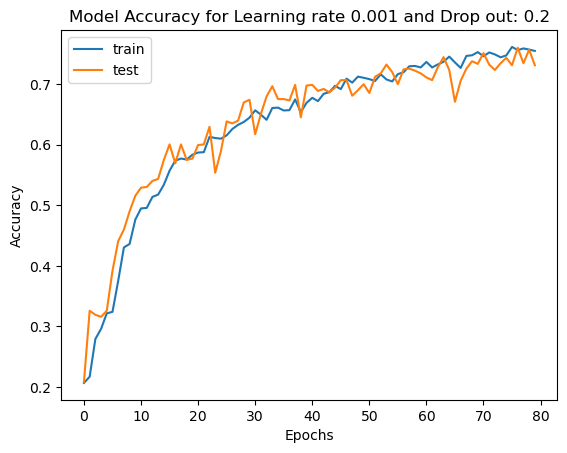

Epoch 1/80
57/57 [==============================] - 105s 2s/step - loss: 8.9121 - accuracy: 0.1798 - val_loss: 1.9723 - val_accuracy: 0.2109
Epoch 2/80
57/57 [==============================] - 104s 2s/step - loss: 1.9739 - accuracy: 0.1958 - val_loss: 1.9664 - val_accuracy: 0.2020
Epoch 3/80
57/57 [==============================] - 113s 2s/step - loss: 1.9728 - accuracy: 0.1985 - val_loss: 1.9714 - val_accuracy: 0.2109
Epoch 4/80
57/57 [==============================] - 115s 2s/step - loss: 1.9729 - accuracy: 0.2051 - val_loss: 1.9646 - val_accuracy: 0.2121
Epoch 5/80
57/57 [==============================] - 113s 2s/step - loss: 1.9719 - accuracy: 0.2079 - val_loss: 1.9685 - val_accuracy: 0.2020
Epoch 6/80
57/57 [==============================] - 116s 2s/step - loss: 1.9732 - accuracy: 0.2013 - val_loss: 1.9665 - val_accuracy: 0.2076
Epoch 7/80
57/57 [==============================] - 115s 2s/step - loss: 1.9734 - accuracy: 0.2029 - val_loss: 1.9743 - val_accuracy: 0.2065
Epoch 8/80
57

Epoch 59/80
57/57 [==============================] - 103s 2s/step - loss: 1.9693 - accuracy: 0.2059 - val_loss: 1.9666 - val_accuracy: 0.2109
Epoch 60/80
57/57 [==============================] - 103s 2s/step - loss: 1.9684 - accuracy: 0.2101 - val_loss: 1.9651 - val_accuracy: 0.2121
Epoch 61/80
57/57 [==============================] - 103s 2s/step - loss: 1.9706 - accuracy: 0.2024 - val_loss: 1.9656 - val_accuracy: 0.2087
Epoch 62/80
57/57 [==============================] - 103s 2s/step - loss: 1.9689 - accuracy: 0.2062 - val_loss: 1.9667 - val_accuracy: 0.2109
Epoch 63/80
57/57 [==============================] - 103s 2s/step - loss: 1.9706 - accuracy: 0.2024 - val_loss: 1.9689 - val_accuracy: 0.2031
Epoch 64/80
57/57 [==============================] - 103s 2s/step - loss: 1.9703 - accuracy: 0.2079 - val_loss: 1.9655 - val_accuracy: 0.2109
Epoch 65/80
57/57 [==============================] - 103s 2s/step - loss: 1.9702 - accuracy: 0.2007 - val_loss: 1.9710 - val_accuracy: 0.2132
Epoch 

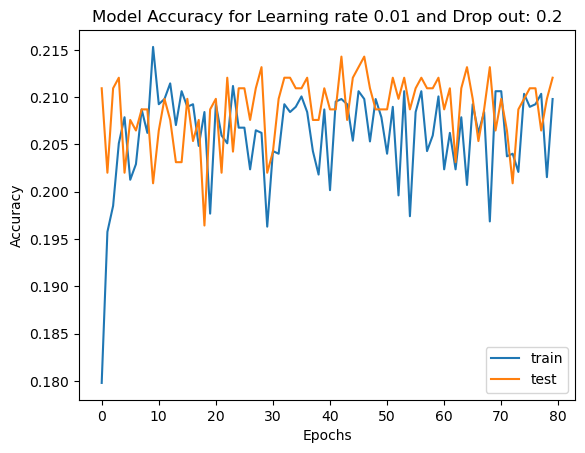

Epoch 1/80
57/57 [==============================] - 106s 2s/step - loss: 2.0714 - accuracy: 0.2046 - val_loss: 1.9884 - val_accuracy: 0.2467
Epoch 2/80
57/57 [==============================] - 104s 2s/step - loss: 1.9758 - accuracy: 0.1955 - val_loss: 1.9750 - val_accuracy: 0.2098
Epoch 3/80
57/57 [==============================] - 104s 2s/step - loss: 1.9600 - accuracy: 0.2324 - val_loss: 1.9237 - val_accuracy: 0.3069
Epoch 4/80
57/57 [==============================] - 104s 2s/step - loss: 1.9260 - accuracy: 0.2489 - val_loss: 1.9248 - val_accuracy: 0.3170
Epoch 5/80
57/57 [==============================] - 104s 2s/step - loss: 1.8975 - accuracy: 0.2819 - val_loss: 1.8367 - val_accuracy: 0.3962
Epoch 6/80
57/57 [==============================] - 105s 2s/step - loss: 1.7886 - accuracy: 0.3508 - val_loss: 1.6980 - val_accuracy: 0.4364
Epoch 7/80
57/57 [==============================] - 104s 2s/step - loss: 1.6729 - accuracy: 0.4064 - val_loss: 1.5892 - val_accuracy: 0.4654
Epoch 8/80
57

Epoch 59/80
57/57 [==============================] - 104s 2s/step - loss: 0.8848 - accuracy: 0.6856 - val_loss: 0.9655 - val_accuracy: 0.6674
Epoch 60/80
57/57 [==============================] - 104s 2s/step - loss: 0.8544 - accuracy: 0.6977 - val_loss: 0.9402 - val_accuracy: 0.6830
Epoch 61/80
57/57 [==============================] - 103s 2s/step - loss: 0.8813 - accuracy: 0.6850 - val_loss: 1.0223 - val_accuracy: 0.6719
Epoch 62/80
57/57 [==============================] - 104s 2s/step - loss: 0.8770 - accuracy: 0.6878 - val_loss: 0.9782 - val_accuracy: 0.6607
Epoch 63/80
57/57 [==============================] - 104s 2s/step - loss: 0.8424 - accuracy: 0.6960 - val_loss: 0.9650 - val_accuracy: 0.6830
Epoch 64/80
57/57 [==============================] - 103s 2s/step - loss: 0.8687 - accuracy: 0.6985 - val_loss: 0.9875 - val_accuracy: 0.6462
Epoch 65/80
57/57 [==============================] - 104s 2s/step - loss: 0.8341 - accuracy: 0.7007 - val_loss: 0.9249 - val_accuracy: 0.6696
Epoch 

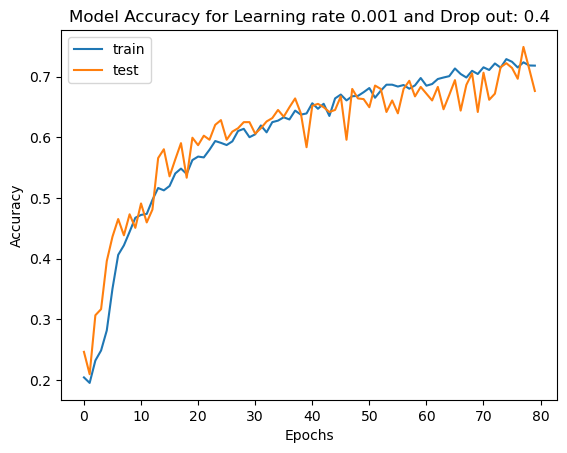

Epoch 1/80
22/57 [==========>...................] - ETA: 1:00 - loss: 12.2299 - accuracy: 0.1733

In [ ]:
models = []
lr_params = [1e-3, 1e-2]
dropout_params = [0.2, 0.4]

for dropout in dropout_params:
    for lr in lr_params:
        buf = create_cnn_model(dropout, lr)
        history = buf.fit(
        train_generator,
        steps_per_epoch=train_generator.n//batch_size,
        validation_data=valid_generator,
        validation_steps=valid_generator.n//batch_size,
        epochs=80,
        verbose=1)
        
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model Accuracy for Learning rate ' + str(lr) + ' and Drop out: ' + str(dropout))
        plt.ylabel('Accuracy')
        plt.xlabel('Epochs')
        plt.legend(['train', 'test'])
        plt.show()
        models.append(buf)


Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_92 (Conv2D)          (None, 224, 224, 32)      2432      
                                                                 
 max_pooling2d_72 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_93 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_73 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_94 (Conv2D)          (None, 56, 56, 96)        55392     
                                                                 
 dropout_67 (Dropout)        (None, 56, 56, 96)      

C:\Users\ADMIN\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/200
57/57 [==============================] - ETA: 0s - loss: 2.0412 - accuracy: 0.2222
Epoch 1: val_accuracy improved from -inf to 0.26674, saving model to .\checkpoint


INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


57/57 [==============================] - 107s 2s/step - loss: 2.0412 - accuracy: 0.2222 - val_loss: 1.9340 - val_accuracy: 0.2667
Epoch 2/200
57/57 [==============================] - ETA: 0s - loss: 1.9104 - accuracy: 0.2808
Epoch 2: val_accuracy did not improve from 0.26674
57/57 [==============================] - 108s 2s/step - loss: 1.9104 - accuracy: 0.2808 - val_loss: 1.9508 - val_accuracy: 0.2433
Epoch 3/200
57/57 [==============================] - ETA: 0s - loss: 1.8712 - accuracy: 0.3012
Epoch 3: val_accuracy improved from 0.26674 to 0.28013, saving model to .\checkpoint


INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


57/57 [==============================] - 109s 2s/step - loss: 1.8712 - accuracy: 0.3012 - val_loss: 1.9040 - val_accuracy: 0.2801
Epoch 4/200
57/57 [==============================] - ETA: 0s - loss: 1.8260 - accuracy: 0.3153
Epoch 4: val_accuracy improved from 0.28013 to 0.34598, saving model to .\checkpoint


INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


57/57 [==============================] - 109s 2s/step - loss: 1.8260 - accuracy: 0.3153 - val_loss: 1.7666 - val_accuracy: 0.3460
Epoch 5/200
57/57 [==============================] - ETA: 0s - loss: 1.7412 - accuracy: 0.3621
Epoch 5: val_accuracy did not improve from 0.34598
57/57 [==============================] - 107s 2s/step - loss: 1.7412 - accuracy: 0.3621 - val_loss: 1.8106 - val_accuracy: 0.2980
Epoch 6/200
57/57 [==============================] - ETA: 0s - loss: 1.7288 - accuracy: 0.3753
Epoch 6: val_accuracy improved from 0.34598 to 0.42969, saving model to .\checkpoint


INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


57/57 [==============================] - 108s 2s/step - loss: 1.7288 - accuracy: 0.3753 - val_loss: 1.5919 - val_accuracy: 0.4297
Epoch 7/200
57/57 [==============================] - ETA: 0s - loss: 1.5862 - accuracy: 0.4240
Epoch 7: val_accuracy improved from 0.42969 to 0.47545, saving model to .\checkpoint


INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


57/57 [==============================] - 108s 2s/step - loss: 1.5862 - accuracy: 0.4240 - val_loss: 1.4655 - val_accuracy: 0.4754
Epoch 8/200
57/57 [==============================] - ETA: 0s - loss: 1.5062 - accuracy: 0.4510
Epoch 8: val_accuracy did not improve from 0.47545
57/57 [==============================] - 108s 2s/step - loss: 1.5062 - accuracy: 0.4510 - val_loss: 1.5518 - val_accuracy: 0.4308
Epoch 9/200
57/57 [==============================] - ETA: 0s - loss: 1.5100 - accuracy: 0.4521
Epoch 9: val_accuracy improved from 0.47545 to 0.51228, saving model to .\checkpoint


INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


57/57 [==============================] - 109s 2s/step - loss: 1.5100 - accuracy: 0.4521 - val_loss: 1.4277 - val_accuracy: 0.5123
Epoch 10/200
57/57 [==============================] - ETA: 0s - loss: 1.4447 - accuracy: 0.4719
Epoch 10: val_accuracy did not improve from 0.51228
57/57 [==============================] - 108s 2s/step - loss: 1.4447 - accuracy: 0.4719 - val_loss: 1.3724 - val_accuracy: 0.5033
Epoch 11/200
57/57 [==============================] - ETA: 0s - loss: 1.3757 - accuracy: 0.4945
Epoch 11: val_accuracy improved from 0.51228 to 0.54018, saving model to .\checkpoint


INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


57/57 [==============================] - 109s 2s/step - loss: 1.3757 - accuracy: 0.4945 - val_loss: 1.3084 - val_accuracy: 0.5402
Epoch 12/200
57/57 [==============================] - ETA: 0s - loss: 1.3546 - accuracy: 0.5066
Epoch 12: val_accuracy improved from 0.54018 to 0.55246, saving model to .\checkpoint


INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


57/57 [==============================] - 109s 2s/step - loss: 1.3546 - accuracy: 0.5066 - val_loss: 1.2758 - val_accuracy: 0.5525
Epoch 13/200
57/57 [==============================] - ETA: 0s - loss: 1.3121 - accuracy: 0.5215
Epoch 13: val_accuracy improved from 0.55246 to 0.57254, saving model to .\checkpoint


INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


57/57 [==============================] - 108s 2s/step - loss: 1.3121 - accuracy: 0.5215 - val_loss: 1.2799 - val_accuracy: 0.5725
Epoch 14/200
57/57 [==============================] - ETA: 0s - loss: 1.2693 - accuracy: 0.5421
Epoch 14: val_accuracy did not improve from 0.57254
57/57 [==============================] - 108s 2s/step - loss: 1.2693 - accuracy: 0.5421 - val_loss: 1.2458 - val_accuracy: 0.5647
Epoch 15/200
57/57 [==============================] - ETA: 0s - loss: 1.2533 - accuracy: 0.5509
Epoch 15: val_accuracy did not improve from 0.57254
57/57 [==============================] - 108s 2s/step - loss: 1.2533 - accuracy: 0.5509 - val_loss: 1.2385 - val_accuracy: 0.5391
Epoch 16/200
57/57 [==============================] - ETA: 0s - loss: 1.2394 - accuracy: 0.5565
Epoch 16: val_accuracy improved from 0.57254 to 0.57812, saving model to .\checkpoint


INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


57/57 [==============================] - 110s 2s/step - loss: 1.2394 - accuracy: 0.5565 - val_loss: 1.1746 - val_accuracy: 0.5781
Epoch 17/200
57/57 [==============================] - ETA: 0s - loss: 1.1989 - accuracy: 0.5680
Epoch 17: val_accuracy did not improve from 0.57812
57/57 [==============================] - 109s 2s/step - loss: 1.1989 - accuracy: 0.5680 - val_loss: 1.2120 - val_accuracy: 0.5737
Epoch 18/200
57/57 [==============================] - ETA: 0s - loss: 1.1692 - accuracy: 0.5837
Epoch 18: val_accuracy improved from 0.57812 to 0.60826, saving model to .\checkpoint


INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


57/57 [==============================] - 109s 2s/step - loss: 1.1692 - accuracy: 0.5837 - val_loss: 1.1304 - val_accuracy: 0.6083
Epoch 19/200
57/57 [==============================] - ETA: 0s - loss: 1.1314 - accuracy: 0.5887
Epoch 19: val_accuracy did not improve from 0.60826
57/57 [==============================] - 108s 2s/step - loss: 1.1314 - accuracy: 0.5887 - val_loss: 1.1124 - val_accuracy: 0.5960
Epoch 20/200
57/57 [==============================] - ETA: 0s - loss: 1.1519 - accuracy: 0.5865
Epoch 20: val_accuracy did not improve from 0.60826
57/57 [==============================] - 108s 2s/step - loss: 1.1519 - accuracy: 0.5865 - val_loss: 1.1898 - val_accuracy: 0.5904
Epoch 21/200
57/57 [==============================] - ETA: 0s - loss: 1.1173 - accuracy: 0.5975
Epoch 21: val_accuracy improved from 0.60826 to 0.63058, saving model to .\checkpoint


INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


57/57 [==============================] - 109s 2s/step - loss: 1.1173 - accuracy: 0.5975 - val_loss: 1.1058 - val_accuracy: 0.6306
Epoch 22/200
57/57 [==============================] - ETA: 0s - loss: 1.1025 - accuracy: 0.6035
Epoch 22: val_accuracy improved from 0.63058 to 0.65960, saving model to .\checkpoint


INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


57/57 [==============================] - 109s 2s/step - loss: 1.1025 - accuracy: 0.6035 - val_loss: 1.0183 - val_accuracy: 0.6596
Epoch 23/200
57/57 [==============================] - ETA: 0s - loss: 1.0850 - accuracy: 0.6154
Epoch 23: val_accuracy did not improve from 0.65960
57/57 [==============================] - 108s 2s/step - loss: 1.0850 - accuracy: 0.6154 - val_loss: 1.0640 - val_accuracy: 0.6183
Epoch 24/200
57/57 [==============================] - ETA: 0s - loss: 1.0590 - accuracy: 0.6231
Epoch 24: val_accuracy did not improve from 0.65960
57/57 [==============================] - 108s 2s/step - loss: 1.0590 - accuracy: 0.6231 - val_loss: 1.0458 - val_accuracy: 0.6272
Epoch 25/200
57/57 [==============================] - ETA: 0s - loss: 1.0635 - accuracy: 0.6200
Epoch 25: val_accuracy did not improve from 0.65960
57/57 [==============================] - 108s 2s/step - loss: 1.0635 - accuracy: 0.6200 - val_loss: 1.0234 - val_accuracy: 0.6484
Epoch 26/200
57/57 [================

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


57/57 [==============================] - 110s 2s/step - loss: 0.9506 - accuracy: 0.6567 - val_loss: 0.9358 - val_accuracy: 0.6674
Epoch 34/200
57/57 [==============================] - ETA: 0s - loss: 0.9490 - accuracy: 0.6622
Epoch 34: val_accuracy improved from 0.66741 to 0.68527, saving model to .\checkpoint


INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


57/57 [==============================] - 109s 2s/step - loss: 0.9490 - accuracy: 0.6622 - val_loss: 0.8967 - val_accuracy: 0.6853
Epoch 35/200
57/57 [==============================] - ETA: 0s - loss: 0.9774 - accuracy: 0.6498
Epoch 35: val_accuracy did not improve from 0.68527
57/57 [==============================] - 108s 2s/step - loss: 0.9774 - accuracy: 0.6498 - val_loss: 0.9700 - val_accuracy: 0.6607
Epoch 36/200
57/57 [==============================] - ETA: 0s - loss: 0.9361 - accuracy: 0.6613
Epoch 36: val_accuracy did not improve from 0.68527
57/57 [==============================] - 112s 2s/step - loss: 0.9361 - accuracy: 0.6613 - val_loss: 0.9355 - val_accuracy: 0.6741
Epoch 37/200
57/57 [==============================] - ETA: 0s - loss: 0.9332 - accuracy: 0.6586
Epoch 37: val_accuracy did not improve from 0.68527
57/57 [==============================] - 112s 2s/step - loss: 0.9332 - accuracy: 0.6586 - val_loss: 0.9272 - val_accuracy: 0.6853
Epoch 38/200
57/57 [================

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


57/57 [==============================] - 109s 2s/step - loss: 0.8873 - accuracy: 0.6737 - val_loss: 0.8904 - val_accuracy: 0.6920
Epoch 43/200
57/57 [==============================] - ETA: 0s - loss: 0.9018 - accuracy: 0.6776
Epoch 43: val_accuracy did not improve from 0.69196
57/57 [==============================] - 107s 2s/step - loss: 0.9018 - accuracy: 0.6776 - val_loss: 0.9106 - val_accuracy: 0.6853
Epoch 44/200
57/57 [==============================] - ETA: 0s - loss: 0.8523 - accuracy: 0.6886
Epoch 44: val_accuracy did not improve from 0.69196
57/57 [==============================] - 109s 2s/step - loss: 0.8523 - accuracy: 0.6886 - val_loss: 0.9383 - val_accuracy: 0.6596
Epoch 45/200
57/57 [==============================] - ETA: 0s - loss: 0.8644 - accuracy: 0.6869
Epoch 45: val_accuracy improved from 0.69196 to 0.69308, saving model to .\checkpoint


INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


57/57 [==============================] - 111s 2s/step - loss: 0.8644 - accuracy: 0.6869 - val_loss: 0.9028 - val_accuracy: 0.6931
Epoch 46/200
57/57 [==============================] - ETA: 0s - loss: 0.8439 - accuracy: 0.6881
Epoch 46: val_accuracy improved from 0.69308 to 0.69978, saving model to .\checkpoint


INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


57/57 [==============================] - 109s 2s/step - loss: 0.8439 - accuracy: 0.6881 - val_loss: 0.8782 - val_accuracy: 0.6998
Epoch 47/200
57/57 [==============================] - ETA: 0s - loss: 0.8303 - accuracy: 0.6982
Epoch 47: val_accuracy did not improve from 0.69978
57/57 [==============================] - 107s 2s/step - loss: 0.8303 - accuracy: 0.6982 - val_loss: 0.8891 - val_accuracy: 0.6942
Epoch 48/200
57/57 [==============================] - ETA: 0s - loss: 0.8368 - accuracy: 0.6963
Epoch 48: val_accuracy did not improve from 0.69978
57/57 [==============================] - 107s 2s/step - loss: 0.8368 - accuracy: 0.6963 - val_loss: 0.8734 - val_accuracy: 0.6975
Epoch 49/200
57/57 [==============================] - ETA: 0s - loss: 0.8357 - accuracy: 0.6971
Epoch 49: val_accuracy did not improve from 0.69978
57/57 [==============================] - 107s 2s/step - loss: 0.8357 - accuracy: 0.6971 - val_loss: 0.8936 - val_accuracy: 0.6763
Epoch 50/200
57/57 [================

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


57/57 [==============================] - 109s 2s/step - loss: 0.8026 - accuracy: 0.7156 - val_loss: 0.8302 - val_accuracy: 0.7132
Epoch 54/200
57/57 [==============================] - ETA: 0s - loss: 0.7704 - accuracy: 0.7249
Epoch 54: val_accuracy did not improve from 0.71317
57/57 [==============================] - 107s 2s/step - loss: 0.7704 - accuracy: 0.7249 - val_loss: 0.8503 - val_accuracy: 0.7098
Epoch 55/200
57/57 [==============================] - ETA: 0s - loss: 0.7944 - accuracy: 0.7150
Epoch 55: val_accuracy improved from 0.71317 to 0.72098, saving model to .\checkpoint


INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


57/57 [==============================] - 108s 2s/step - loss: 0.7944 - accuracy: 0.7150 - val_loss: 0.8140 - val_accuracy: 0.7210
Epoch 56/200
57/57 [==============================] - ETA: 0s - loss: 0.7911 - accuracy: 0.7203
Epoch 56: val_accuracy did not improve from 0.72098
57/57 [==============================] - 107s 2s/step - loss: 0.7911 - accuracy: 0.7203 - val_loss: 0.8738 - val_accuracy: 0.7098
Epoch 57/200
57/57 [==============================] - ETA: 0s - loss: 0.8010 - accuracy: 0.7070
Epoch 57: val_accuracy improved from 0.72098 to 0.72433, saving model to .\checkpoint


INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


57/57 [==============================] - 109s 2s/step - loss: 0.8010 - accuracy: 0.7070 - val_loss: 0.8449 - val_accuracy: 0.7243
Epoch 58/200
57/57 [==============================] - ETA: 0s - loss: 0.7658 - accuracy: 0.7181
Epoch 58: val_accuracy did not improve from 0.72433
57/57 [==============================] - 107s 2s/step - loss: 0.7658 - accuracy: 0.7181 - val_loss: 0.8489 - val_accuracy: 0.7210
Epoch 59/200
57/57 [==============================] - ETA: 0s - loss: 0.7830 - accuracy: 0.7098
Epoch 59: val_accuracy did not improve from 0.72433
57/57 [==============================] - 107s 2s/step - loss: 0.7830 - accuracy: 0.7098 - val_loss: 0.8534 - val_accuracy: 0.6853
Epoch 60/200
57/57 [==============================] - ETA: 0s - loss: 0.7530 - accuracy: 0.7338
Epoch 60: val_accuracy did not improve from 0.72433
57/57 [==============================] - 107s 2s/step - loss: 0.7530 - accuracy: 0.7338 - val_loss: 0.8048 - val_accuracy: 0.7188
Epoch 61/200
57/57 [================

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


57/57 [==============================] - 108s 2s/step - loss: 0.7352 - accuracy: 0.7349 - val_loss: 0.8095 - val_accuracy: 0.7266
Epoch 63/200
57/57 [==============================] - ETA: 0s - loss: 0.7453 - accuracy: 0.7404
Epoch 63: val_accuracy did not improve from 0.72656
57/57 [==============================] - 107s 2s/step - loss: 0.7453 - accuracy: 0.7404 - val_loss: 0.8782 - val_accuracy: 0.6830
Epoch 64/200
57/57 [==============================] - ETA: 0s - loss: 0.7462 - accuracy: 0.7282
Epoch 64: val_accuracy did not improve from 0.72656
57/57 [==============================] - 107s 2s/step - loss: 0.7462 - accuracy: 0.7282 - val_loss: 0.8127 - val_accuracy: 0.7243
Epoch 65/200
57/57 [==============================] - ETA: 0s - loss: 0.7261 - accuracy: 0.7412
Epoch 65: val_accuracy did not improve from 0.72656
57/57 [==============================] - 108s 2s/step - loss: 0.7261 - accuracy: 0.7412 - val_loss: 0.8486 - val_accuracy: 0.7042
Epoch 66/200
57/57 [================

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


57/57 [==============================] - 109s 2s/step - loss: 0.6762 - accuracy: 0.7627 - val_loss: 0.7728 - val_accuracy: 0.7333
Epoch 71/200
57/57 [==============================] - ETA: 0s - loss: 0.6892 - accuracy: 0.7580
Epoch 71: val_accuracy did not improve from 0.73326
57/57 [==============================] - 107s 2s/step - loss: 0.6892 - accuracy: 0.7580 - val_loss: 0.8584 - val_accuracy: 0.7076
Epoch 72/200
57/57 [==============================] - ETA: 0s - loss: 0.7057 - accuracy: 0.7423
Epoch 72: val_accuracy did not improve from 0.73326
57/57 [==============================] - 107s 2s/step - loss: 0.7057 - accuracy: 0.7423 - val_loss: 0.8161 - val_accuracy: 0.7154
Epoch 73/200
57/57 [==============================] - ETA: 0s - loss: 0.7098 - accuracy: 0.7528
Epoch 73: val_accuracy did not improve from 0.73326
57/57 [==============================] - 107s 2s/step - loss: 0.7098 - accuracy: 0.7528 - val_loss: 0.7762 - val_accuracy: 0.7321
Epoch 74/200
57/57 [================

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


57/57 [==============================] - 109s 2s/step - loss: 0.6946 - accuracy: 0.7583 - val_loss: 0.7686 - val_accuracy: 0.7400
Epoch 78/200
57/57 [==============================] - ETA: 0s - loss: 0.6546 - accuracy: 0.7679
Epoch 78: val_accuracy did not improve from 0.73996
57/57 [==============================] - 107s 2s/step - loss: 0.6546 - accuracy: 0.7679 - val_loss: 0.8257 - val_accuracy: 0.7221
Epoch 79/200
57/57 [==============================] - ETA: 0s - loss: 0.6526 - accuracy: 0.7662
Epoch 79: val_accuracy did not improve from 0.73996
57/57 [==============================] - 107s 2s/step - loss: 0.6526 - accuracy: 0.7662 - val_loss: 0.8309 - val_accuracy: 0.7243
Epoch 80/200
57/57 [==============================] - ETA: 0s - loss: 0.6385 - accuracy: 0.7695
Epoch 80: val_accuracy did not improve from 0.73996
57/57 [==============================] - 107s 2s/step - loss: 0.6385 - accuracy: 0.7695 - val_loss: 0.8849 - val_accuracy: 0.7188
Epoch 81/200
57/57 [================

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


57/57 [==============================] - 109s 2s/step - loss: 0.6467 - accuracy: 0.7610 - val_loss: 0.7727 - val_accuracy: 0.7444
Epoch 82/200
57/57 [==============================] - ETA: 0s - loss: 0.6555 - accuracy: 0.7616
Epoch 82: val_accuracy did not improve from 0.74442
57/57 [==============================] - 108s 2s/step - loss: 0.6555 - accuracy: 0.7616 - val_loss: 0.7765 - val_accuracy: 0.7321
Epoch 83/200
57/57 [==============================] - ETA: 0s - loss: 0.6640 - accuracy: 0.7668
Epoch 83: val_accuracy did not improve from 0.74442
57/57 [==============================] - 109s 2s/step - loss: 0.6640 - accuracy: 0.7668 - val_loss: 0.8217 - val_accuracy: 0.7121
Epoch 84/200
57/57 [==============================] - ETA: 0s - loss: 0.6335 - accuracy: 0.7729
Epoch 84: val_accuracy did not improve from 0.74442
57/57 [==============================] - 109s 2s/step - loss: 0.6335 - accuracy: 0.7729 - val_loss: 0.7663 - val_accuracy: 0.7422
Epoch 85/200
57/57 [================

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


57/57 [==============================] - 109s 2s/step - loss: 0.6595 - accuracy: 0.7665 - val_loss: 0.7254 - val_accuracy: 0.7522
Epoch 89/200
57/57 [==============================] - ETA: 0s - loss: 0.6205 - accuracy: 0.7808
Epoch 89: val_accuracy did not improve from 0.75223
57/57 [==============================] - 107s 2s/step - loss: 0.6205 - accuracy: 0.7808 - val_loss: 0.8212 - val_accuracy: 0.7299
Epoch 90/200
57/57 [==============================] - ETA: 0s - loss: 0.6395 - accuracy: 0.7729
Epoch 90: val_accuracy did not improve from 0.75223
57/57 [==============================] - 108s 2s/step - loss: 0.6395 - accuracy: 0.7729 - val_loss: 0.7462 - val_accuracy: 0.7355
Epoch 91/200
57/57 [==============================] - ETA: 0s - loss: 0.6084 - accuracy: 0.7832
Epoch 91: val_accuracy did not improve from 0.75223
57/57 [==============================] - 108s 2s/step - loss: 0.6084 - accuracy: 0.7832 - val_loss: 0.7496 - val_accuracy: 0.7444
Epoch 92/200
57/57 [================

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


57/57 [==============================] - 109s 2s/step - loss: 0.5866 - accuracy: 0.7894 - val_loss: 0.7114 - val_accuracy: 0.7656
Epoch 96/200
57/57 [==============================] - ETA: 0s - loss: 0.5802 - accuracy: 0.7910
Epoch 96: val_accuracy did not improve from 0.76562
57/57 [==============================] - 108s 2s/step - loss: 0.5802 - accuracy: 0.7910 - val_loss: 0.7993 - val_accuracy: 0.7277
Epoch 97/200
57/57 [==============================] - ETA: 0s - loss: 0.6070 - accuracy: 0.7786
Epoch 97: val_accuracy did not improve from 0.76562
57/57 [==============================] - 107s 2s/step - loss: 0.6070 - accuracy: 0.7786 - val_loss: 0.7149 - val_accuracy: 0.7578
Epoch 98/200
57/57 [==============================] - ETA: 0s - loss: 0.5728 - accuracy: 0.7941
Epoch 98: val_accuracy did not improve from 0.76562
57/57 [==============================] - 108s 2s/step - loss: 0.5728 - accuracy: 0.7941 - val_loss: 0.7691 - val_accuracy: 0.7321
Epoch 99/200
57/57 [================

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


57/57 [==============================] - 108s 2s/step - loss: 0.5124 - accuracy: 0.8202 - val_loss: 0.7221 - val_accuracy: 0.7701
Epoch 112/200
57/57 [==============================] - ETA: 0s - loss: 0.5138 - accuracy: 0.8114
Epoch 112: val_accuracy did not improve from 0.77009
57/57 [==============================] - 107s 2s/step - loss: 0.5138 - accuracy: 0.8114 - val_loss: 0.7253 - val_accuracy: 0.7578
Epoch 113/200
57/57 [==============================] - ETA: 0s - loss: 0.5684 - accuracy: 0.7930
Epoch 113: val_accuracy did not improve from 0.77009
57/57 [==============================] - 108s 2s/step - loss: 0.5684 - accuracy: 0.7930 - val_loss: 0.7549 - val_accuracy: 0.7511
Epoch 114/200
57/57 [==============================] - ETA: 0s - loss: 0.5410 - accuracy: 0.8070
Epoch 114: val_accuracy did not improve from 0.77009
57/57 [==============================] - 107s 2s/step - loss: 0.5410 - accuracy: 0.8070 - val_loss: 0.7496 - val_accuracy: 0.7400
Epoch 115/200
57/57 [=========

Epoch 141/200
57/57 [==============================] - ETA: 0s - loss: 0.4947 - accuracy: 0.8194
Epoch 141: val_accuracy did not improve from 0.77009
57/57 [==============================] - 108s 2s/step - loss: 0.4947 - accuracy: 0.8194 - val_loss: 0.7703 - val_accuracy: 0.7455
Epoch 142/200
57/57 [==============================] - ETA: 0s - loss: 0.4957 - accuracy: 0.8194
Epoch 142: val_accuracy did not improve from 0.77009
57/57 [==============================] - 107s 2s/step - loss: 0.4957 - accuracy: 0.8194 - val_loss: 0.7684 - val_accuracy: 0.7545
Epoch 143/200
57/57 [==============================] - ETA: 0s - loss: 0.4542 - accuracy: 0.8387
Epoch 143: val_accuracy did not improve from 0.77009
57/57 [==============================] - 107s 2s/step - loss: 0.4542 - accuracy: 0.8387 - val_loss: 0.7658 - val_accuracy: 0.7522
Epoch 144/200
57/57 [==============================] - ETA: 0s - loss: 0.4884 - accuracy: 0.8300
Epoch 144: val_accuracy did not improve from 0.77009
57/57 [===

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


57/57 [==============================] - 108s 2s/step - loss: 0.4460 - accuracy: 0.8365 - val_loss: 0.7133 - val_accuracy: 0.7723
Epoch 148/200
57/57 [==============================] - ETA: 0s - loss: 0.4450 - accuracy: 0.8389
Epoch 148: val_accuracy did not improve from 0.77232
57/57 [==============================] - 107s 2s/step - loss: 0.4450 - accuracy: 0.8389 - val_loss: 0.7550 - val_accuracy: 0.7578
Epoch 149/200
57/57 [==============================] - ETA: 0s - loss: 0.4328 - accuracy: 0.8477
Epoch 149: val_accuracy did not improve from 0.77232
57/57 [==============================] - 107s 2s/step - loss: 0.4328 - accuracy: 0.8477 - val_loss: 0.7458 - val_accuracy: 0.7690
Epoch 150/200
57/57 [==============================] - ETA: 0s - loss: 0.4666 - accuracy: 0.8354
Epoch 150: val_accuracy did not improve from 0.77232
57/57 [==============================] - 108s 2s/step - loss: 0.4666 - accuracy: 0.8354 - val_loss: 0.8153 - val_accuracy: 0.7589
Epoch 151/200
57/57 [=========

Epoch 177/200
57/57 [==============================] - ETA: 0s - loss: 0.4318 - accuracy: 0.8422
Epoch 177: val_accuracy did not improve from 0.77232
57/57 [==============================] - 107s 2s/step - loss: 0.4318 - accuracy: 0.8422 - val_loss: 0.7274 - val_accuracy: 0.7578
Epoch 178/200
57/57 [==============================] - ETA: 0s - loss: 0.3848 - accuracy: 0.8582
Epoch 178: val_accuracy did not improve from 0.77232
57/57 [==============================] - 107s 2s/step - loss: 0.3848 - accuracy: 0.8582 - val_loss: 0.8112 - val_accuracy: 0.7511
Epoch 179/200
57/57 [==============================] - ETA: 0s - loss: 0.3905 - accuracy: 0.8549
Epoch 179: val_accuracy did not improve from 0.77232
57/57 [==============================] - 108s 2s/step - loss: 0.3905 - accuracy: 0.8549 - val_loss: 0.7767 - val_accuracy: 0.7701
Epoch 180/200
57/57 [==============================] - ETA: 0s - loss: 0.4002 - accuracy: 0.8555
Epoch 180: val_accuracy did not improve from 0.77232
57/57 [===

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


57/57 [==============================] - 109s 2s/step - loss: 0.4083 - accuracy: 0.8488 - val_loss: 0.7797 - val_accuracy: 0.7757
Epoch 190/200
57/57 [==============================] - ETA: 0s - loss: 0.3938 - accuracy: 0.8557
Epoch 190: val_accuracy did not improve from 0.77567
57/57 [==============================] - 108s 2s/step - loss: 0.3938 - accuracy: 0.8557 - val_loss: 0.8157 - val_accuracy: 0.7634
Epoch 191/200
57/57 [==============================] - ETA: 0s - loss: 0.3721 - accuracy: 0.8621
Epoch 191: val_accuracy did not improve from 0.77567
57/57 [==============================] - 108s 2s/step - loss: 0.3721 - accuracy: 0.8621 - val_loss: 0.8122 - val_accuracy: 0.7556
Epoch 192/200
57/57 [==============================] - ETA: 0s - loss: 0.3746 - accuracy: 0.8618
Epoch 192: val_accuracy did not improve from 0.77567
57/57 [==============================] - 110s 2s/step - loss: 0.3746 - accuracy: 0.8618 - val_loss: 0.7851 - val_accuracy: 0.7734
Epoch 193/200
57/57 [=========

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


57/57 [==============================] - 109s 2s/step - loss: 0.3865 - accuracy: 0.8588 - val_loss: 0.7901 - val_accuracy: 0.7857
Epoch 200/200
57/57 [==============================] - ETA: 0s - loss: 0.3849 - accuracy: 0.8586
Epoch 200: val_accuracy did not improve from 0.78571
57/57 [==============================] - 110s 2s/step - loss: 0.3849 - accuracy: 0.8586 - val_loss: 0.7472 - val_accuracy: 0.7746


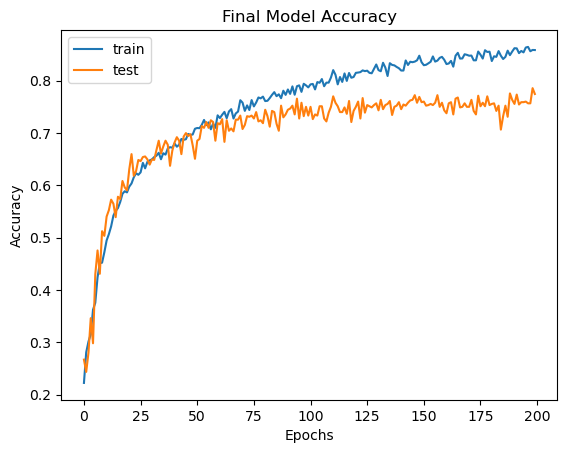

In [22]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath= os.curdir + '/checkpoint',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
    ,verbose = 1)

final_model = create_cnn_model(0.2, 0.001)
final_model.summary()
history = final_model.fit(
            train_generator,
            steps_per_epoch=train_generator.n//batch_size,
            validation_data=valid_generator,
            validation_steps=valid_generator.n//batch_size,
            epochs=200,
            callbacks=[model_checkpoint_callback])

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Final Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [23]:
baseModel = Sequential()
baseModel.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (224,224,3)))
baseModel.add(MaxPooling2D(pool_size=(2,2)))


baseModel.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
baseModel.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))


baseModel.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
baseModel.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

baseModel.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
baseModel.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

baseModel.add(Flatten())

baseModel.add(Dense(512))
baseModel.add(Activation('relu'))
baseModel.add(Dense(8, activation = "softmax"))

baseModel.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

C:\Users\ADMIN\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/50
57/57 [==============================] - 105s 2s/step - loss: 2.0536 - accuracy: 0.2010 - val_loss: 1.9973 - val_accuracy: 0.2087
Epoch 2/50
57/57 [==============================] - 105s 2s/step - loss: 1.9703 - accuracy: 0.2117 - val_loss: 1.9109 - val_accuracy: 0.2623
Epoch 3/50
57/57 [==============================] - 104s 2s/step - loss: 1.8961 - accuracy: 0.2682 - val_loss: 1.7606 - val_accuracy: 0.3750
Epoch 4/50
57/57 [==============================] - 104s 2s/step - loss: 1.8066 - accuracy: 0.3257 - val_loss: 1.6256 - val_accuracy: 0.4040
Epoch 5/50
57/57 [==============================] - 110s 2s/step - loss: 1.7221 - accuracy: 0.3596 - val_loss: 1.5242 - val_accuracy: 0.4509
Epoch 6/50
57/57 [==============================] - 104s 2s/step - loss: 1.6204 - accuracy: 0.4047 - val_loss: 1.5083 - val_accuracy: 0.4286
Epoch 7/50
57/57 [==============================] - 104s 2s/step - loss: 1.5426 - accuracy: 0.4400 - val_loss: 1.4275 - val_accuracy: 0.4554
Epoch 8/50
57

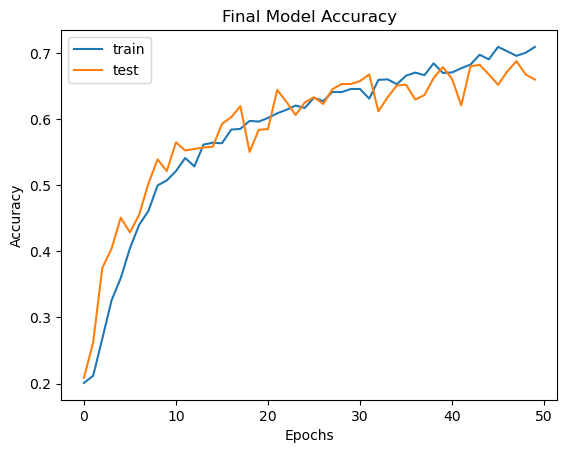

In [24]:
baseHistory = baseModel.fit(
            train_generator,
            steps_per_epoch=train_generator.n//batch_size,
            validation_data=valid_generator,
            validation_steps=valid_generator.n//batch_size,
            epochs=50)

plt.plot(baseHistory.history['accuracy'])
plt.plot(baseHistory.history['val_accuracy'])
plt.title('Final Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()
models.append(buf)

In [28]:
from keras.models import load_model

mymodel = load_model(os.curdir + '/checkpoint')

In [47]:
mymodel.evaluate(valid_generator)

15/15 [==============================] - 5s 354ms/step - loss: 0.7868 - accuracy: 0.7859


[0.7867737412452698, 0.7859459519386292]

In [72]:
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

predictions = mymodel.predict(test_generator, valid_generator.n//batch_size)


15/15 [==============================] - 8s 518ms/step


In [73]:
predicted_classes = np.argmax(predictions, axis=1)
print(confusion_matrix(valid_generator.classes, predicted_classes))

classes = ['Tana', 'Rosy', 'Pingpong','Lisianthus', 'Hydrangeas', 'Chrysanthemum', 'Calimerio', 'Babi']

print(classification_report(valid_generator.classes, predicted_classes, target_names=classes))

[[175   0   1   3   3   2   0   2]
 [  1  54   2   3   8   2   0   1]
 [  2   0 111   0   0   1   1  24]
 [  7   1   0  90   4   0   0   2]
 [  1   3   0   7 181   1   0   1]
 [  3   2   0   7   7  51   2   0]
 [  0   1   1   1   0   0  31   0]
 [  5   0   9   0   0   0   0 111]]
               precision    recall  f1-score   support

         Tana       0.90      0.94      0.92       186
         Rosy       0.89      0.76      0.82        71
     Pingpong       0.90      0.80      0.84       139
   Lisianthus       0.81      0.87      0.84       104
   Hydrangeas       0.89      0.93      0.91       194
Chrysanthemum       0.89      0.71      0.79        72
    Calimerio       0.91      0.91      0.91        34
         Babi       0.79      0.89      0.83       125

     accuracy                           0.87       925
    macro avg       0.87      0.85      0.86       925
 weighted avg       0.87      0.87      0.87       925



## Result 

In [70]:
mymodel.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_92 (Conv2D)          (None, 224, 224, 32)      2432      
                                                                 
 max_pooling2d_72 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_93 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_73 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_94 (Conv2D)          (None, 56, 56, 96)        55392     
                                                                 
 dropout_67 (Dropout)        (None, 56, 56, 96)      